In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_combined
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series
from neurodsp.filt import filter_signal


from fooof import FOOOF
from fooof.bands import Bands
from fooof.utils import trim_spectrum
from fooof.plts import plot_spectrum
from fooof.plts.spectra import plot_spectrum_shading
from fooof.plts.annotate import plot_annotated_model

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
#exps = [0, -0.5, -1, -1.5, -2]
exps = np.arange(-2.25, -0.25, 0.25)

In [4]:
# Define our bands of interest
bands = Bands({'delta' : [2, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 25]})

In [5]:
shade_colors = ['#e8dc35', '#46b870', '#1882d9', '#a218d9']

In [6]:
n_seconds = 2
fs = 100

In [7]:
times = create_times(n_seconds, fs)

In [8]:
sigs = []
for exp in exps:
    sigs.append(sim_powerlaw(n_seconds, fs, exp))

In [9]:
cmap = [plt.cm.gist_heat(ind) for ind in np.linspace(0, 1, len(exps) + 2)]

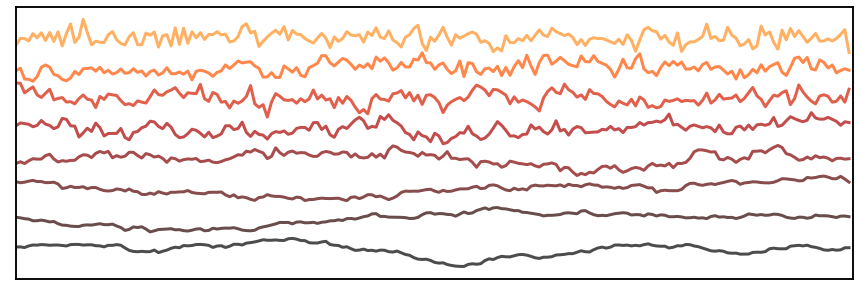

In [10]:
_, ax = plt.subplots(figsize=(15, 5))
for ind, sig in enumerate(sigs):
    ax.plot(times, sig+5*ind, color=cmap[ind], alpha=0.7, lw=3.)
ax.set_xlim([0, n_seconds])
ax.set(xticks=[], yticks=[]);
plt.savefig('multi_noise_time_series.svg', dpi=300)

In [11]:
ns_2 = 25
fs_2 = 1000

In [12]:
white = sim_powerlaw(ns_2, fs_2, 0)
pink = sim_powerlaw(ns_2, fs_2, -1)

In [13]:
times = create_times(ns_2, fs_2)

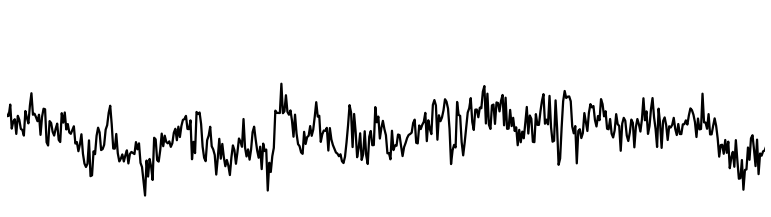

In [14]:
_, ax = plt.subplots(figsize=(12, 4))
plot_time_series(times, pink, xlim=[3, 3.5], ax=ax)
plt.gca().axis('off')
plt.savefig('pink_noise_time_series.svg', dpi=300)

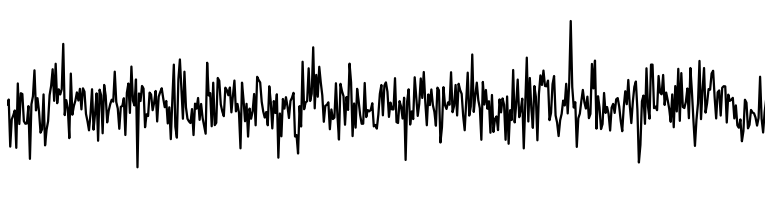

In [15]:
_, ax = plt.subplots(figsize=(12, 4))
plot_time_series(times, white, xlim=[3, 3.5], ax=ax)
plt.gca().axis('off')
plt.savefig('white_noise_time_series.svg', dpi=300)

In [16]:
filt_xlim = [3, 3.5]
plt_kwargs = {'xlabel' : '', 'ylabel' : '', 'lw' : 3}

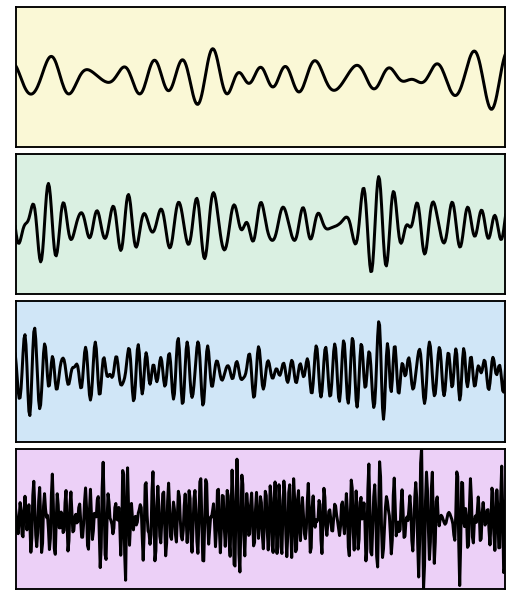

In [17]:
# Create a plot of the data filtered into different frequency ranges
_, axes = plt.subplots(len(bands), 1, figsize=(8, 9))
for ax, color, (label, f_range) in zip(axes, shade_colors, bands):

    band_sig = filter_signal(white, fs, 'bandpass', f_range)
    plot_time_series(times, band_sig, ax=ax,
                     xlim=filt_xlim, ylim=(-1.25, 1.25), **plt_kwargs)
    ax.axvspan(filt_xlim[0], filt_xlim[1], alpha=0.2, color=color)
    ax.set_xticks([]); ax.set_yticks([]); 
    
plt.subplots_adjust(hspace=0.05)
plt.savefig('white_noise_filters.svg', dpi=300)

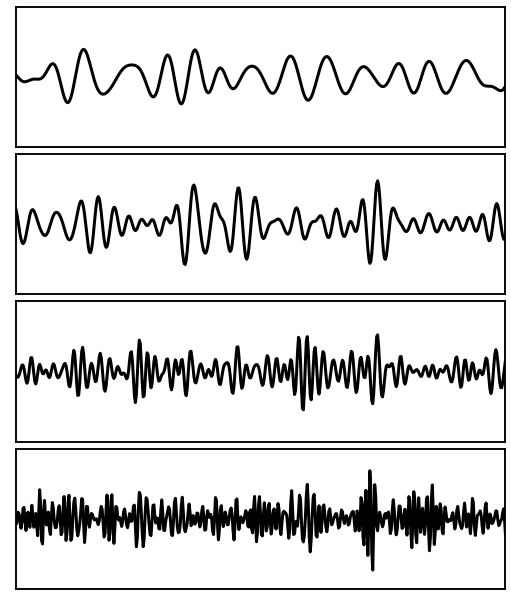

In [18]:
# Create a plot of the data filtered into different frequency ranges
_, axes = plt.subplots(len(bands), 1, figsize=(8, 9))
for ax, color, (label, f_range) in zip(axes, shade_colors, bands):

    band_sig = filter_signal(pink, fs, 'bandpass', f_range)
    plot_time_series(times, band_sig, ax=ax,
                     xlim=filt_xlim, ylim=(-1.25, 1.25), **plt_kwargs)
    #ax.axvspan(filt_xlim[0], filt_xlim[1], alpha=0.2, color=color)
    ax.set_xticks([]); ax.set_yticks([]); 
    
plt.subplots_adjust(hspace=0.05)
plt.savefig('pink_noise_filters_nc.svg', dpi=300)

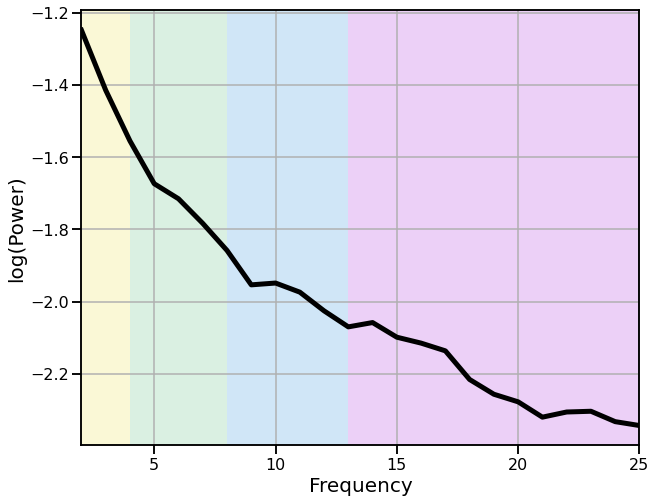

In [19]:
# Plot the power spectrum of the simulated signal
freqs, powers = trim_spectrum(*compute_spectrum(pink, fs, nperseg=fs), [2, 25])
plot_spectrum_shading(freqs, powers, lw=5, color='black', log_powers=True,
                      shades=bands.definitions, shade_colors=shade_colors)

plt.xlim([2, 25])
#plt.ylim([-2.2, -1.25])
plt.savefig('pink_noise_psd.svg', dpi=300)

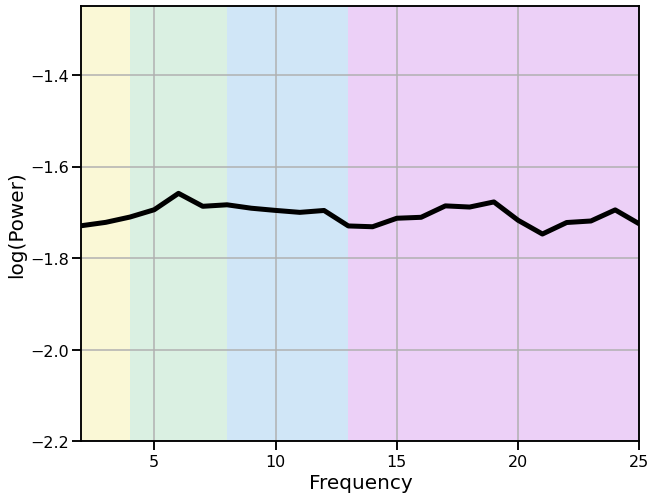

In [20]:
# Plot the power spectrum of the simulated signal
freqs, powers = trim_spectrum(*compute_spectrum(white, fs, nperseg=fs), [2, 25])
plot_spectrum_shading(freqs, powers, lw=5, color='black', log_powers=True,
                      shades=bands.definitions, shade_colors=shade_colors)

plt.xlim([2, 25])
plt.ylim([-2.2, -1.25])
plt.savefig('white_noise_psd.svg', dpi=300)

In [21]:
import matplotlib.gridspec as gridspec

In [22]:
# gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5])
# ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1])

# pxx, freqs, bins, im = ax2.specgram(pink, NFFT=5*fs, Fs=fs, noverlap=fs, cmap='inferno')
# ax1.plot(pink[500:1000], color='black')
# ax1.axis('off')
# ax2.set(xticks=[], yticks=[]);
# ax2.set(xlabel='time', ylabel='frequency');
# plt.savefig('pink_noise_spectrogram_w_time.pdf')

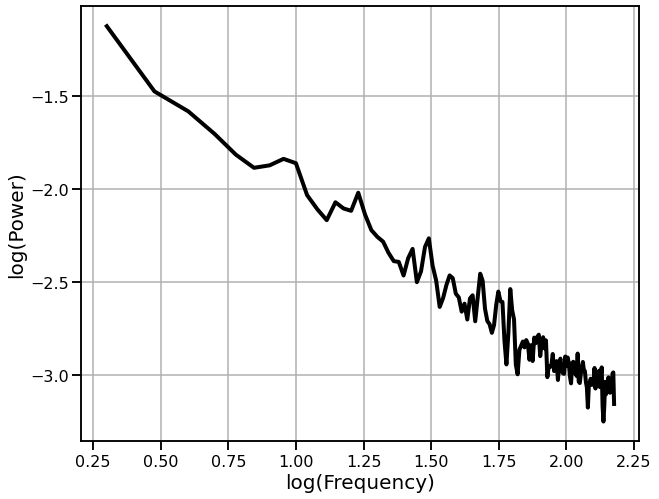

In [23]:
freqs, powers = compute_spectrum(pink, fs_2)
plot_spectrum(*trim_spectrum(freqs, powers, [2, 150]), 
              log_freqs=True, log_powers=True, lw=4, color='black')
plt.savefig('pink_noise_spectrum.svg', dpi=300)

In [24]:
comps = {'sim_powerlaw' : {'exponent' : -1, 'f_range' : [1, 150]}, 
         'sim_bursty_oscillation' : {'freq' : 10}}
sig = sim_combined(ns_2, fs_2, comps)

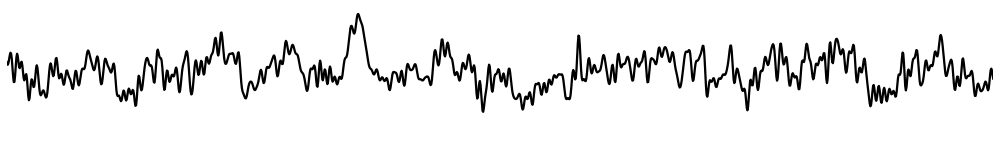

In [25]:
plot_time_series(times, sig, xlim=[2, 3.5])
plt.gca().axis('off')
plt.savefig('oscillation_time_series.svg', dpi=300)

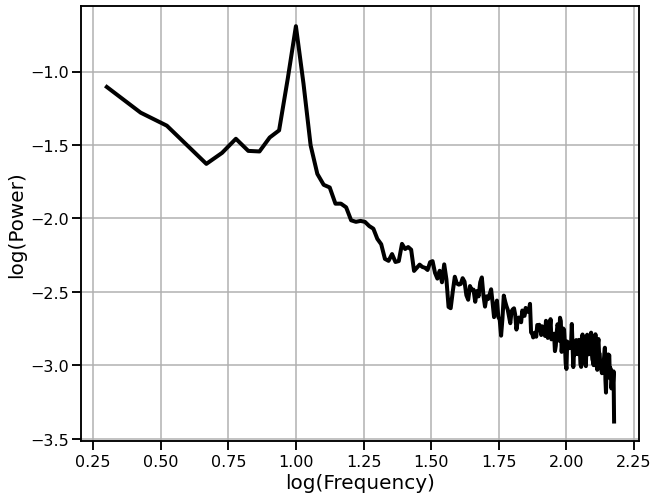

In [26]:
freqs, powers = compute_spectrum(sig, fs_2, nperseg=1.5*fs_2, noverlap=fs_2)
plot_spectrum(*trim_spectrum(freqs, powers, [2, 150]),
              log_freqs=True, log_powers=True, lw=4, color='black')
plt.savefig('oscillation_spectrum.svg', dpi=300)

In [27]:
fm = FOOOF(min_peak_height=1)
#fm = FOOOF()
fm.fit(freqs, powers, [2, 50])


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.67 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



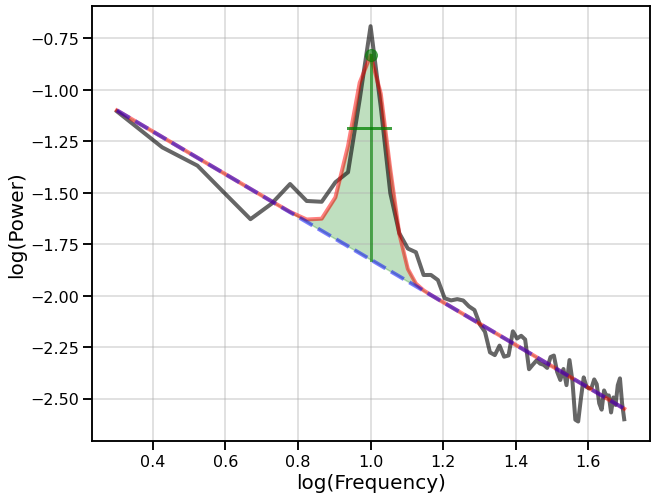

In [28]:
_, ax = plt.subplots(figsize=(10, 8))
plot_annotated_model(fm, plt_log=True, annotate_peaks=False, annotate_aperiodic=False, ax=ax)
ax.legend().remove()
plt.savefig('model_fit.svg', dpi=300)

In [29]:
# from scipy.signal import spectrogram
# f1, t1, pxx = spectrogram(pink, fs_2)

In [30]:
# f, t, Sxx = spectrogram(pink, fs_2, nperseg=5*fs, noverlap=fs,)
# plt.pcolormesh(t, f, Sxx, cmap='inferno')
# #plt.ylabel('Frequency [Hz]')
# #plt.xlabel('Time [sec]')

In [31]:
# _, ax = plt.subplots(figsize=(12, 5))
# ax.imshow(pxx, cmap='inferno')

In [32]:
white = sim_powerlaw(ns_2, fs_2, 0)

In [33]:
ww = np.reshape(white, (-1, 100))

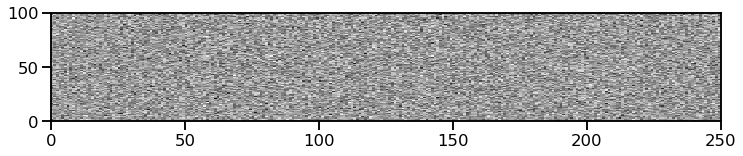

In [34]:
_, ax = plt.subplots(figsize=(12, 2))
ax.pcolormesh(ww.T, cmap='Greys')

NameError: name 'pp' is not defined

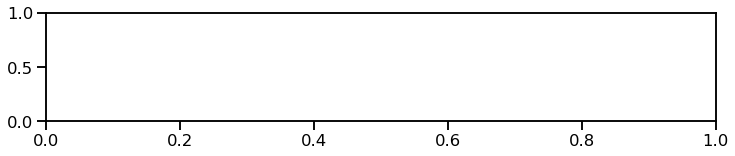

In [36]:
_, ax = plt.subplots(figsize=(12, 2))
ax.imshow(pp.T, cmap='Greys')

NameError: name 'pxx' is not defined

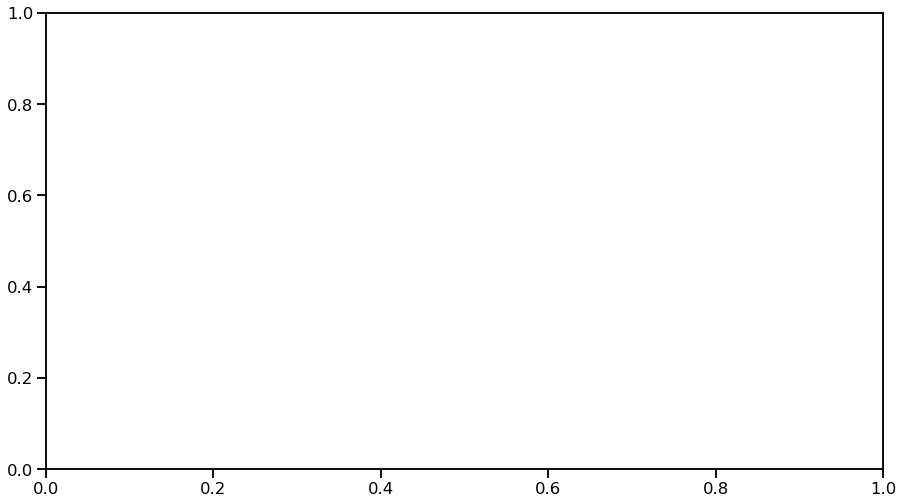

In [37]:
_, ax = plt.subplots(figsize=(15, 8.4))
ax.imshow(np.flipud(10*np.log10(pxx)), cmap='inferno', interpolation='hamming')
ax.set(xticks=[], yticks=[]);
plt.savefig('test.pdf')#, dpi=600)

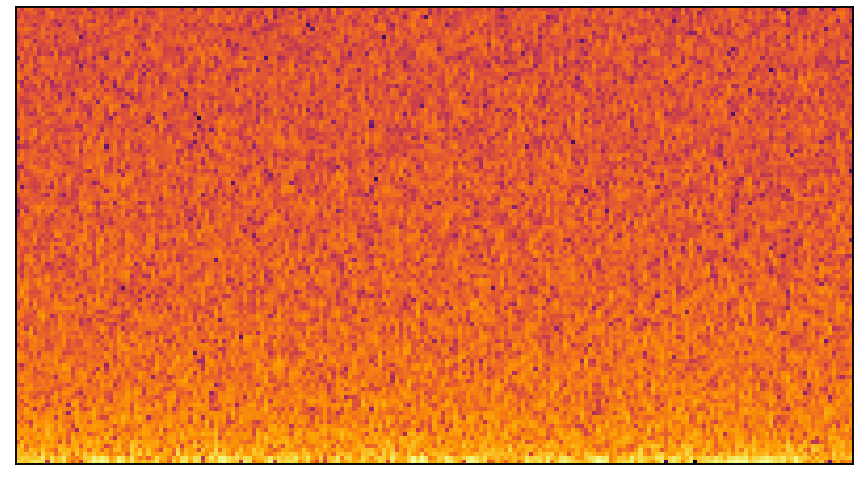

In [38]:
_, ax = plt.subplots(figsize=(15, 8.4))
#pxx, freqs, bins, im = ax.specgram(pink[0:1000], NFFT=int(0.5*fs), Fs=fs, noverlap=0.25*fs, cmap='inferno')
pxx, freqs, bins, im = ax.specgram(pink, NFFT=int(2.25*fs), Fs=fs, noverlap=fs, cmap='inferno')
ax.set(xticks=[], yticks=[]);
#ax.set(xlabel='time', ylabel='frequency')
#plt.savefig('test_pink_noise_spectrogram_nl.png', dpi=300)
plt.savefig('pink_noise_spectrogram.svg', dpi=300)

In [39]:
#exps2 = [-2, -1.5, -1, -0.5, 0]
#exps2 = [-1.5, -0.5, 0.]
#exps2 = [-1.5, -1.0, 0.]
exps2 = [-2, -1.0, 0.]
comb = np.array([])
for exp in exps2:
    temp = sim_powerlaw(100, fs, exp)
    comb = np.concatenate((comb, temp))

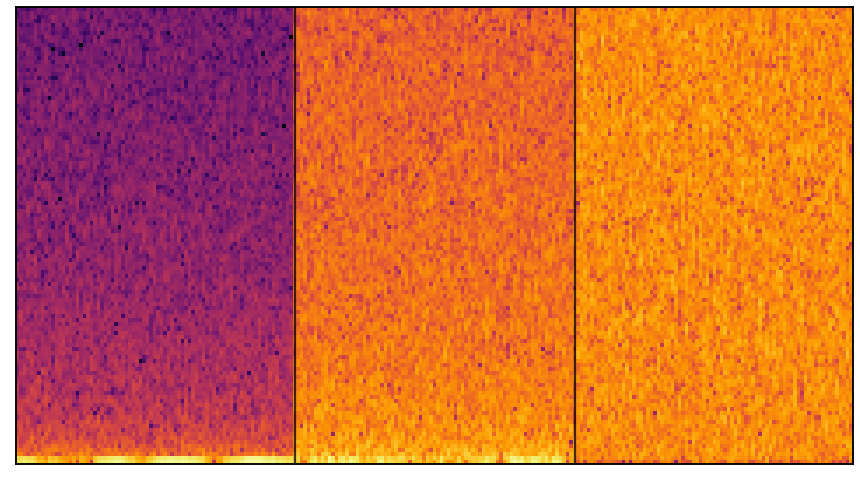

In [40]:
cmap = 'inferno'
#_, ax = plt.subplots(figsize=(12, 5))
_, ax = plt.subplots(figsize=(15, 8.4))
pxx, freqs, bins, im = ax.specgram(comb, NFFT=int(2.25*fs), Fs=fs, noverlap=fs, cmap=cmap)
ax.set(xticks=[], yticks=[]);
#ax.set(xlabel='time', ylabel='frequency')
ax.axvline(x=100, color='black', alpha=0.75)
ax.axvline(x=200, color='black', alpha=0.75)
plt.savefig('multi_noise_spectrogram_nl.svg', dpi=300)
#plt.savefig('multi_noise_spectrogram.svg', dpi=300)
#plt.savefig('multi_noise_spectrogram.pdf')